##### **Imports**

In [186]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,  roc_curve, auc

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Exercise 1**

In [187]:
df_signal_train = pd.read_csv('BDT_signal_train.txt', sep='\s+',header=None)
df_signal_train.columns = ['X','Y','Z']
df_signal_test = pd.read_csv('BDT_signal_test.txt', sep='\s+',header=None)
df_signal_test.columns = ['X','Y','Z']
df_background_train = pd.read_csv('BDT_background_train.txt', sep='\s+',header=None)
df_background_train.columns = ['X','Y','Z']
df_background_test = pd.read_csv('BDT_background_test.txt', sep='\s+',header=None)
df_background_test.columns = ['X','Y','Z']

In [188]:
signal_train_X, signal_train_Y, signal_train_Z = df_signal_train['X'].values, df_signal_train['Y'].values, df_signal_train['Z'].values
background_train_X, background_train_Y, background_train_Z = df_background_train['X'].values, df_background_train['Y'].values, df_background_train['Z'].values

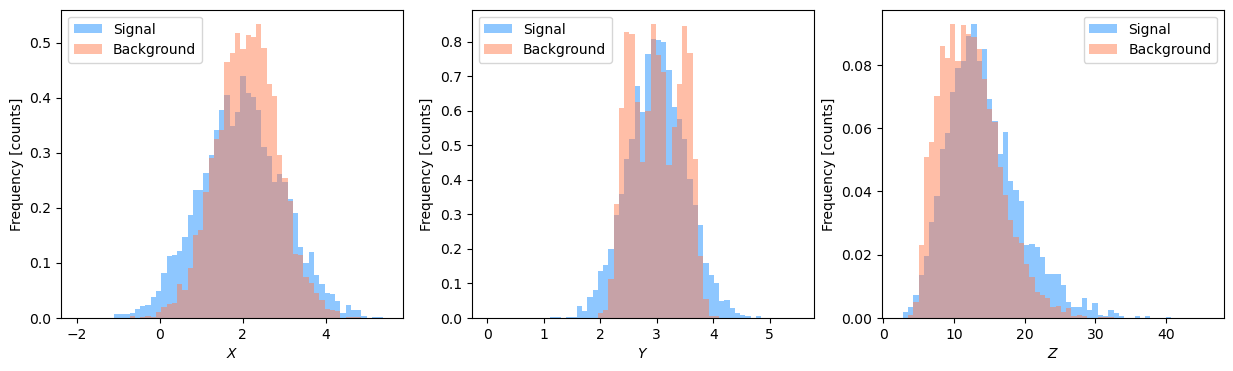

In [189]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))  # Adjusting the figsize to accommodate three subplots

ax[0].hist(signal_train_X,bins=np.linspace(-2,5.5,60),density=True,alpha=0.5,label = 'Signal',color='dodgerblue')
ax[0].hist(background_train_X,bins=np.linspace(-2,5.5,60),density=True,alpha=0.5,label = 'Background',color='coral')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('Frequency [counts]')
ax[0].legend(loc = 'best',frameon = True)

ax[1].hist(signal_train_Y,bins=np.linspace(0,5.5,60),density=True,alpha=0.5,label = 'Signal',color='dodgerblue')
ax[1].hist(background_train_Y,bins=np.linspace(0,5.5,60),density=True,alpha=0.5,label = 'Background',color='coral')
ax[1].set_xlabel('$Y$')
ax[1].set_ylabel('Frequency [counts]')
ax[1].legend(loc = 'best',frameon = True)

ax[2].hist(signal_train_Z,bins=np.linspace(2,46,60),density=True,alpha=0.5,label = 'Signal',color='dodgerblue')
ax[2].hist(background_train_Z,bins=np.linspace(2,46,60),density=True,alpha=0.5,label = 'Background',color='coral')
ax[2].set_xlabel('$Z$')
ax[2].set_ylabel('Frequency [counts]')
ax[2].legend(loc = 'best',frameon = True)
plt.show()

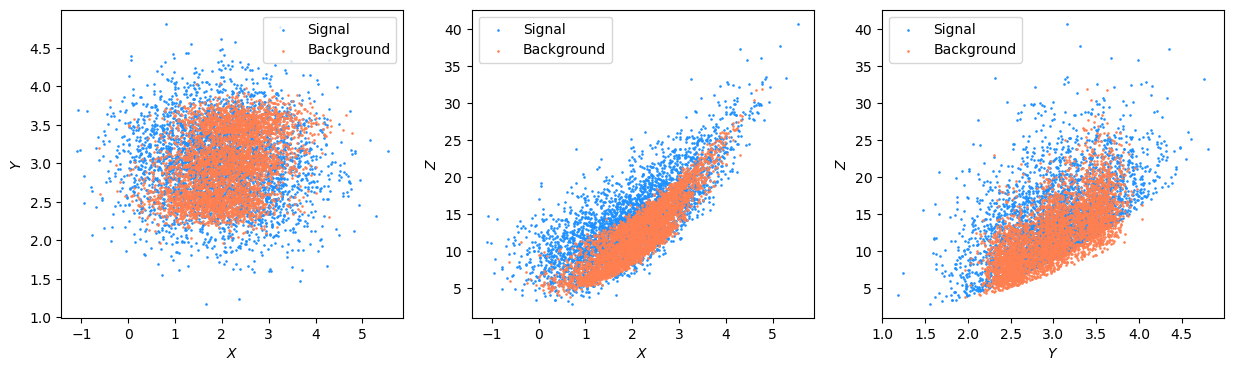

In [190]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))  # Adjusting the figsize to accommodate three subplots

ax[0].scatter(signal_train_X,signal_train_Y,s=0.75,alpha=1.,label = 'Signal',color='dodgerblue')
ax[0].scatter(background_train_X,background_train_Y,s=0.75,alpha=1.,label = 'Background',color='coral')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')
ax[0].legend(loc = 'best',frameon = True)

ax[1].scatter(signal_train_X,signal_train_Z,s=0.75,alpha=1.,label = 'Signal',color='dodgerblue')
ax[1].scatter(background_train_X,background_train_Z,s=0.75,alpha=1.,label = 'Background',color='coral')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Z$')
ax[1].legend(loc = 'best',frameon = True)

ax[2].scatter(signal_train_Y,signal_train_Z,s=0.75,alpha=1.,label = 'Signal',color='dodgerblue')
ax[2].scatter(background_train_Y,background_train_Z,s=0.75,alpha=1.,label = 'Background',color='coral')
ax[2].set_xlabel('$Y$')
ax[2].set_ylabel('$Z$')
ax[2].legend(loc = 'best',frameon = True)
plt.show()

In [191]:
df_signal_train['label'] = 1
df_background_train['label'] = 0
df_signal_test['label'] = 1
df_background_test['label'] = 0

train_data = pd.concat([df_signal_train, df_background_train])
test_data = pd.concat([df_signal_test, df_background_test])

X_train = train_data[['X', 'Y', 'Z']]
y_train = train_data['label']
X_test = test_data[['X', 'Y', 'Z']]
y_test = test_data['label']

In [192]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model parameters
params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
epochs = 100

bst = xgb.train(params, dtrain, epochs)

preds = bst.predict(dtest)
predictions = [1 if i > 0.5 else 0 for i in preds]

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 97.50%


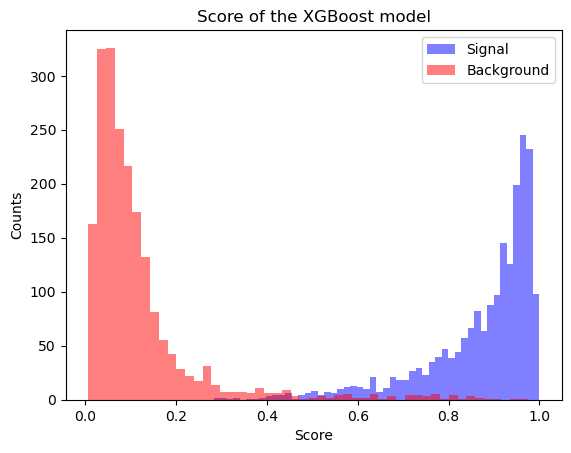

In [193]:
test_data['decision_score'] = preds  # preds are the predicted probabilities from the model

# Separate the decision scores for signal and background
signal_decision_scores = test_data[test_data['label'] == 1]['decision_score']
background_decision_scores = test_data[test_data['label'] == 0]['decision_score']

# Plotting
plt.hist(signal_decision_scores, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_decision_scores, bins=50, alpha=0.5, label='Background', color='red')

plt.legend(loc='best')
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title('Score of the XGBoost model')
plt.show()

In [194]:
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

# Train the AdaBoost model
ada_model.fit(X_train, y_train)

# Make predictions
preds = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 94.30%


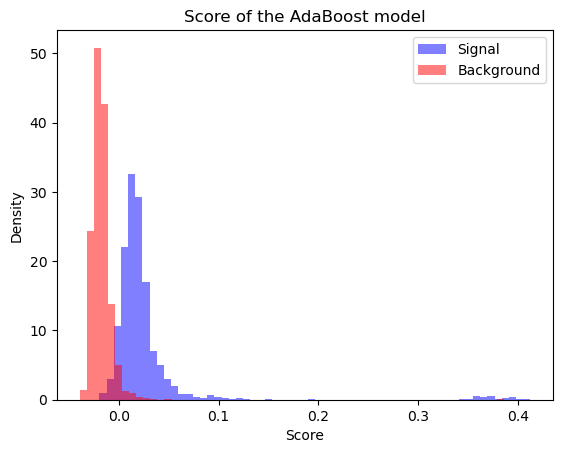

In [195]:
try:
    bdt_scores = ada_model.decision_function(X_test)
except AttributeError:  # If decision_function is not available, use .predict_proba() instead
    # The second column represents the positive class
    bdt_scores = ada_model.predict_proba(X_test)[:, 1]

signal_scores = bdt_scores[y_test == 1]
background_scores = bdt_scores[y_test == 0]

plt.hist(signal_scores, bins=60, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_scores, bins=60, alpha=0.5, label='Background', color='red', density=True)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Score of the AdaBoost model')
plt.legend(loc='best')
plt.show()

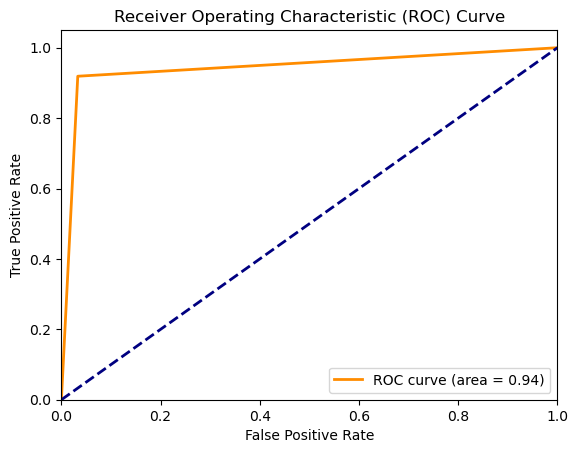

In [196]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### **Exercise 2**

In [197]:
df_16var = pd.read_csv('BDt_16var.txt', sep='\s+',header=None)
df_16var_signal = df_16var.iloc[::2].reset_index(drop=True)
df_16var_background = df_16var.iloc[1::2].reset_index(drop=True)

In [198]:
df_signal_train, df_signal_test = train_test_split(df_16var_signal, test_size=0.2, random_state=42)
df_background_train, df_background_test = train_test_split(df_16var_background, test_size=0.2, random_state=42)

df_signal_train = df_signal_train.drop(df_signal_train.columns[0], axis=1)
df_signal_test = df_signal_test.drop(df_signal_test.columns[0], axis=1)
df_background_train = df_background_train.drop(df_background_train.columns[0], axis=1)
df_background_test = df_background_test.drop(df_background_test.columns[0], axis=1)

df_signal_train['label'] = 1
df_background_train['label'] = 0
df_signal_test['label'] = 1
df_background_test['label'] = 0

train_data = pd.concat([df_signal_train, df_background_train])
test_data = pd.concat([df_signal_test, df_background_test])

X_train = train_data.iloc[:,:16]
y_train = train_data['label']
X_test = test_data.iloc[:,:16]
y_test = test_data['label']

In [199]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model parameters
params = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}
epochs = 100

bst = xgb.train(params, dtrain, epochs)

preds = bst.predict(dtest)
predictions = [1 if i > 0.5 else 0 for i in preds]

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.55%


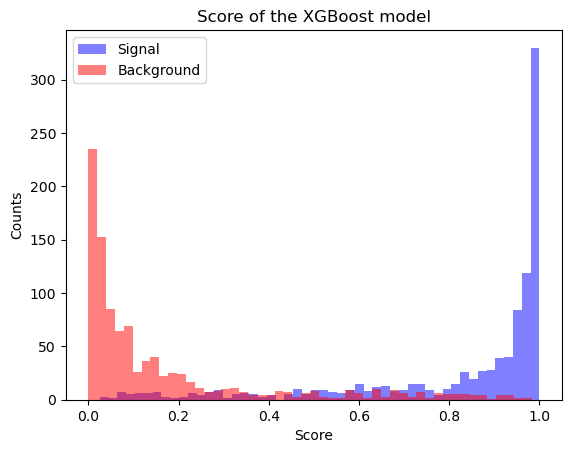

In [200]:
test_data['decision_score'] = preds  # preds are the predicted probabilities from the model

# Separate the decision scores for signal and background
signal_decision_scores = test_data[test_data['label'] == 1]['decision_score']
background_decision_scores = test_data[test_data['label'] == 0]['decision_score']

# Plotting
plt.hist(signal_decision_scores, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_decision_scores, bins=50, alpha=0.5, label='Background', color='red')

plt.legend(loc='best')
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title('Score of the XGBoost model')
plt.show()

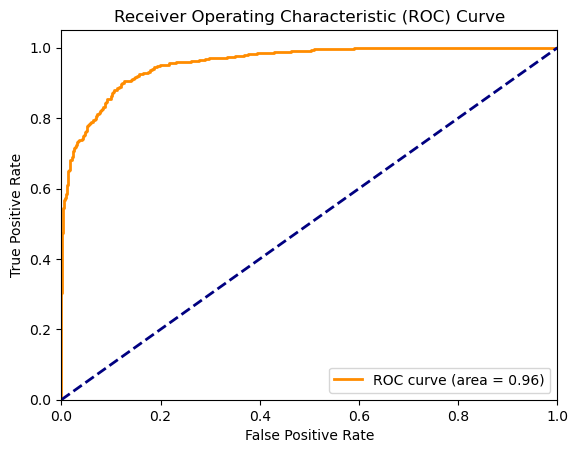

In [201]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [202]:
ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)

# Train the AdaBoost model
ada_model.fit(X_train, y_train)

# Make predictions
preds = ada_model.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 88.25%


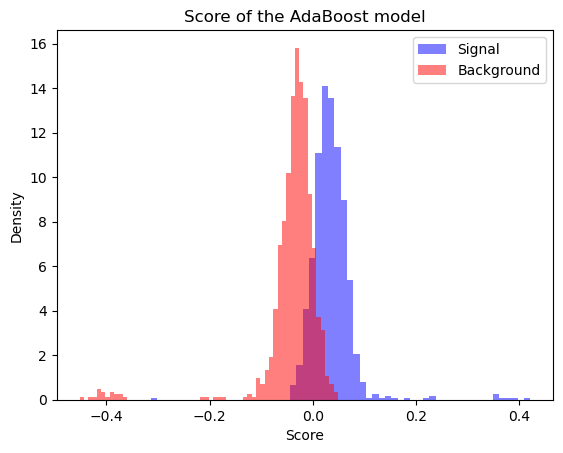

In [203]:
try:
    bdt_scores = ada_model.decision_function(X_test)
except AttributeError:  # If decision_function is not available, use .predict_proba() instead
    # The second column represents the positive class
    bdt_scores = ada_model.predict_proba(X_test)[:, 1]

signal_scores = bdt_scores[y_test == 1]
background_scores = bdt_scores[y_test == 0]

plt.hist(signal_scores, bins=60, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_scores, bins=60, alpha=0.5, label='Background', color='red', density=True)

plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Score of the AdaBoost model')
plt.legend(loc='best')
plt.show()